In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89


In [1]:
import torch
print(torch.__version__)

1.10.0+cu102


c:\Users\김기후\KimGihu\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# import packages
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.nn import functional as F

from tqdm import tqdm
from torchvision.utils import save_image,make_grid

In [3]:
dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)

cuda


In [4]:
# hyper-parameter
batch_size = 100
x_dim = 28*28
hidden_dim = 400
latent_dim = 200

lr = 1e-3
epochs = 30

In [5]:
# LOAD or Download Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## AutoEncoder (AE)

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(True),
            nn.Linear(100,50),
            nn.ReLU(True), nn.Linear(50, 12), nn.ReLU(True), nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(True),
            nn.Linear(12,50),
            nn.ReLU(True),
            nn.Linear(50,100),
            nn.ReLU(True), nn.Linear(100, 28*28), nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x_ = self.decoder(x)
        x_hat = torch.sigmoid(x_)
        return x_hat

In [7]:
model_ae = autoencoder().to(DEVICE)

In [8]:
from torch.optim import Adam
criterion_AE = nn.BCELoss()
optimizer_AE = Adam(model_ae.parameters(), lr=lr)

In [9]:
def loss_function_ae(x_hat, x):
    reproduction_loss_ae = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    return reproduction_loss_ae


In [11]:
# Train AutoEncoder(AE)
print("Start training AE...")
model_ae.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # print(x.shape)
        x = x.view(batch_size, x_dim)
        # print(x.shape)
        x = x.to(DEVICE)

        # forward
        x_hat = model_ae(x)
        loss = loss_function_ae(x_hat, x)
        
        #backward
        optimizer_AE.zero_grad()
        # print(loss)
        overall_loss += loss.item() 
        
        loss.backward()
        optimizer_AE.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    # print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss.data[0])


print("Finish...")
        

Start training AE...
	Epoch 1 complete! 	Average Loss:  321.3773333811561
	Epoch 2 complete! 	Average Loss:  319.14841614279004
	Epoch 3 complete! 	Average Loss:  318.0640409145451
	Epoch 4 complete! 	Average Loss:  317.419023209255
	Epoch 5 complete! 	Average Loss:  316.8868146455029
	Epoch 6 complete! 	Average Loss:  316.41113499713066
	Epoch 7 complete! 	Average Loss:  315.97255080081385
	Epoch 8 complete! 	Average Loss:  315.615031204351
	Epoch 9 complete! 	Average Loss:  315.29476138616445
	Epoch 10 complete! 	Average Loss:  315.02540761294864
	Epoch 11 complete! 	Average Loss:  314.5937961707012
	Epoch 12 complete! 	Average Loss:  314.2556358253339
	Epoch 13 complete! 	Average Loss:  313.8068449042675
	Epoch 14 complete! 	Average Loss:  313.39843886946994
	Epoch 15 complete! 	Average Loss:  312.9898349462646
	Epoch 16 complete! 	Average Loss:  312.60036581150877
	Epoch 17 complete! 	Average Loss:  312.2504066999687
	Epoch 18 complete! 	Average Loss:  311.91291318864774
	Epoch 19 

In [13]:
# Generate images from test dataset
import matplotlib.pyplot as plt

model_ae.eval()    

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [15]:
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat = model_ae(x)

100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


In [16]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

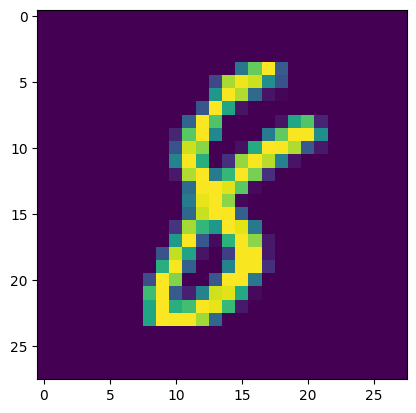

In [17]:
show_image(x, idx=0)

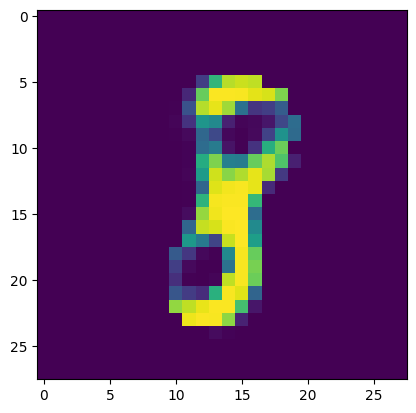

In [18]:
show_image(x_hat, idx=0)

## Variational AutoEncoder (VAE)

In [ ]:
# Define model : Variational AutoEncoder (VAE)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
# Define Loss Function and optimizer
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# Train Variational AutoEncoder(VAE)
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        print(loss)
        print(loss.item())
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish..")

Start training VAE...
tensor(11033.9629, device='cuda:0', grad_fn=<AddBackward0>)
11033.962890625
tensor(10948.9043, device='cuda:0', grad_fn=<AddBackward0>)
10948.904296875
tensor(10884.1582, device='cuda:0', grad_fn=<AddBackward0>)
10884.158203125
tensor(10738.2246, device='cuda:0', grad_fn=<AddBackward0>)
10738.224609375
tensor(10332.3115, device='cuda:0', grad_fn=<AddBackward0>)
10332.3115234375
tensor(10617.2910, device='cuda:0', grad_fn=<AddBackward0>)
10617.291015625
tensor(10754.8633, device='cuda:0', grad_fn=<AddBackward0>)
10754.86328125
tensor(10972.3184, device='cuda:0', grad_fn=<AddBackward0>)
10972.318359375
tensor(10705.0742, device='cuda:0', grad_fn=<AddBackward0>)
10705.07421875
tensor(10969.6855, device='cuda:0', grad_fn=<AddBackward0>)
10969.685546875
tensor(10775.3887, device='cuda:0', grad_fn=<AddBackward0>)
10775.388671875
tensor(10371.9795, device='cuda:0', grad_fn=<AddBackward0>)
10371.9794921875
tensor(10660.4531, device='cuda:0', grad_fn=<AddBackward0>)
10660.

KeyboardInterrupt: 

In [ ]:
# Generate images from test dataset
import matplotlib.pyplot as plt

model.eval()    

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=784, out_features=400, bias=True)
    (FC_input2): Linear(in_features=400, out_features=400, bias=True)
    (FC_mean): Linear(in_features=400, out_features=200, bias=True)
    (FC_var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=200, out_features=400, bias=True)
    (FC_hidden2): Linear(in_features=400, out_features=400, bias=True)
    (FC_output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)

100%|██████████| 100/100 [00:02<00:00, 49.96it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

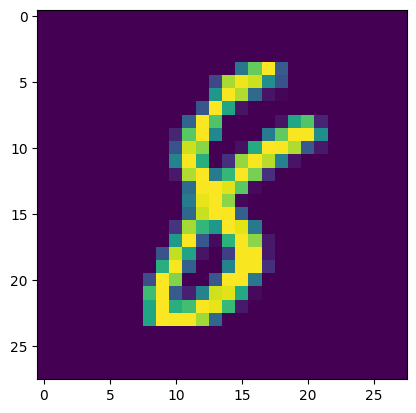

In [ ]:
show_image(x, idx=0)

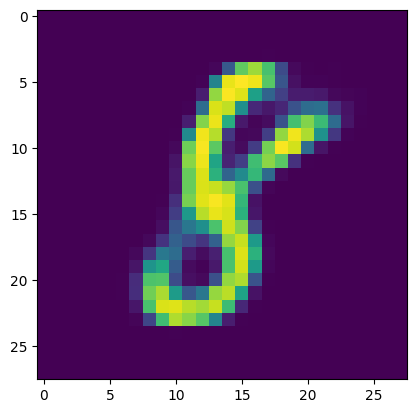

In [ ]:
show_image(x_hat, idx=0)

## Conditional Variational Auto-Encoder (CVAE)

In [19]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(DEVICE)

In [20]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, class_size):
        super(CVAE, self).__init__()
        self.feature_size = input_dim
        self.class_size = class_size

        # encoder 
        self.fc1 = nn.Linear(self.feature_size + self.class_size, hidden_dim)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # decoder
        self.fc3 = nn.Linear(latent_dim + class_size, 400)
        self.fc4 = nn.Linear(400, input_dim)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x, c): # Q(z|x, c)
        """
        x:(bs, feature_size)
        c:(bs, class_size)
        """
        inputs = torch.cat([x,c], 1) # (bs, input_dim + class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decoder(self, z, c): # P(x|z, c)
        '''
        z : (bs, latent_size)
        c : (bs, class_size)
        '''
        inputs = torch.cat([z,c], 1) # (bs, latent_dim + class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))
    
    def forward(self, x, c):
        mu, logvar = self.encoder(x.view(-1, 28*28), c)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, c), mu, logvar

In [25]:
# to create a CVAE model
num_classes = 10
model_CVAE = CVAE(28*28, hidden_dim, latent_dim, num_classes).to(DEVICE)

optimizer_CVAE = optim.Adam(model_CVAE.parameters(), lr=lr)

In [27]:
def loss_function_CVAE(x_hat, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_hat, x, x.view(-1,784), reduction='sum')
    KLD = -0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
import numpy as np

a = np.array(['+ CB V High Fault', '+ DC I High Fault', 'A FLUX High Fault',
 'A FLUX Low Fault', 'A+ Driver Fault', 'A- Driver Fault', 'A-* Driver Fault',
 'B FLUX Low Fault', 'C FLUX Low Fault', 'C+* Driver Fault',
 'DV/DT High Fault', 'DV/DT Low Fault', 'Dump Switch Fault', 'Fiber Fault',
 'Gate Duty Cycl Fault', 'MOD I High Fault', 'Oil Level High Fault',
 'SCR AC Input Fault', 'SCR Contactor Fault', 'SCR Firing Circ Fault',
 'SNS PPS Missing', 'TPS Fault'])

print(a.shape)

(22,)
